## Autoformer Training and Validation script

We use this script for training and validation of the Autoformer model on our dataset. We only imported this script, but the whole code which we used can be found at https://github.com/thuml/Autoformer

In [1]:
import torch
print(torch.cuda.is_available())		 # To see if we have cuda available
print(torch.cuda.device_count()) 		# To see how many GPUs we have
print(torch.cuda.get_device_name())   	# To see what the devices are called
print(torch.cuda.current_device())		# To see which device we are using


True
1
NVIDIA GeForce GTX 1650 Ti
0


In [2]:
torch.cuda.set_device(0) # Set the device to use

In [3]:
import argparse
import os
import torch
from exp.exp_main import Exp_Main #exp stands for experiments
import random
import numpy as np
from utils.tools import dotdict

fix_seed = 2021 
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

# basic config
parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
parser.add_argument('--model_id', type=str, required=True, default='test', help='model id') #The id of the model
parser.add_argument('--model', type=str, required=True, default='Autoformer', #The model to use
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type') #The dataset to use
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file') #The root path of the data file
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file') #The data file
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')#预测类别
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task') #What kind of target feature to use in training We use MS meaning we have multiple columns but only one target
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints') #The location of the model checkpoints

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')# The input sequence length
parser.add_argument('--label_len', type=int, default=48, help='start token length')#label_lenght
parser.add_argument('--pred_len', type=int, default=24, help='prediction sequence length')#prediction sequence length

# model define
parser.add_argument('--bucket_size', type=int, default=4, help='for Reformer')
parser.add_argument('--n_hashes', type=int, default=4, help='for Reformer')
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')#encoder input size
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')#decoder input size
parser.add_argument('--c_out', type=int, default=7, help='output size')#output size
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')#dimension of model
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')#num of heads 
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')#num of encoder layers
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')#num of decoder layers
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')#dimension of fcn
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')#window size of moving average
parser.add_argument('--factor', type=int, default=1, help='attn factor')#attn factor不太理解
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')#dropout
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')#activation function default=gelu
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in encoder')
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')# num_workers for data loader
parser.add_argument('--itr', type=int, default=2, help='experiments times')#experiments times
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')#train epoch
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')#batchsize
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')#patience: early stopping
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')#lr
parser.add_argument('--des', type=str, default='test', help='exp description')#test
parser.add_argument('--loss', type=str, default='mse', help='loss function')#loss is mse
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')#adjust learning-rate
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# args = parser.parse_args()
args = dotdict()
args.target = 'T(degC)'
args.des = 'test'
args.dropout = 0.05
args.num_workers = 10
args.gpu = 0
args.lradj = 'type1'
args.devices = '0'
args.use_gpu = True
args.use_multi_gpu = False

args.freq = 'h'
args.checkpoints = './checkpoints/'
args.bucket_size = 4
args.n_hashes = 4
args.is_trainging = True
args.root_path = r"C:\Users\Legion\Documents\An_1_Data_Science\Weather_project"
args.data_path ='UBB_weather_jan2008_may2023_cleaned.csv' 
args.model_id='weather_120_12_univar'
args.model = 'Autoformer'
args.data = 'custom'
args.features = 'MS'
args.seq_len = 120
args.label_len = 48
args.pred_len = 12
args.e_layers = 2
args.d_layers = 1
args.n_heads = 3
args.factor = 1
args.enc_in = 15
args.dec_in =15
args.c_out = 1
args.d_model = 512
args.des = 'Exp'
args.itr = 1
args.d_ff = 2048
args.moving_avg = 25
args.factor = 1
args.distil = True
args.output_attention = False
args.patience= 3
args.learning_rate = 0.0001
args.batch_size = 128 
args.embed = 'timeF'
args.activation = 'gelu'
args.use_amp = False
args.loss = 'mse'
args.train_epochs = 3
print('Args in experiment:')
print(args)

Exp = Exp_Main




Args in experiment:
{'target': 'T(degC)', 'des': 'Exp', 'dropout': 0.05, 'num_workers': 10, 'gpu': 0, 'lradj': 'type1', 'devices': '0', 'use_gpu': True, 'use_multi_gpu': False, 'freq': 'h', 'checkpoints': './checkpoints/', 'bucket_size': 4, 'n_hashes': 4, 'is_trainging': True, 'root_path': 'C:\\Users\\Legion\\Documents\\An_1_Data_Science\\autoformer\\Autoformer\\weather', 'data_path': 'UBB_weather_jan2008_may2023_cleaned.csv', 'model_id': 'weather_120_12_univar', 'model': 'Autoformer', 'data': 'custom', 'features': 'MS', 'seq_len': 120, 'label_len': 48, 'pred_len': 12, 'e_layers': 2, 'd_layers': 1, 'n_heads': 3, 'factor': 1, 'enc_in': 15, 'dec_in': 15, 'c_out': 15, 'd_model': 512, 'itr': 1, 'd_ff': 2048, 'moving_avg': 25, 'distil': True, 'output_attention': False, 'patience': 3, 'learning_rate': 0.0001, 'batch_size': 128, 'embed': 'timeF', 'activation': 'gelu', 'use_amp': False, 'loss': 'mse', 'train_epochs': 3}


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

for ii in range(args.itr):#
    # setting record of experiments
    setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
        args.model_id,
        args.model,
        args.data,
        args.features,
        args.seq_len,
        args.label_len,
        args.pred_len,
        args.d_model,
        args.n_heads,
        args.e_layers,
        args.d_layers,
        args.d_ff,
        args.factor,
        args.embed,
        args.distil,
        args.des, ii)

    exp = Exp(args)  # set experiments
    print(1)
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    print(2)
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)
    torch.cuda.empty_cache()
    print(3)



Use GPU: cuda:0
1
>>>>>>>start training : weather_120_12_univar_Autoformer_custom_ftMS_sl120_ll48_pl12_dm512_nh3_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 111381
val 13929
test 13928
	iters: 100, epoch: 1 | loss: 0.1397745
	speed: 1.5975s/iter; left time: 4011.2125s
	iters: 200, epoch: 1 | loss: 0.1342800
	speed: 1.1684s/iter; left time: 2816.9231s
	iters: 300, epoch: 1 | loss: 0.1115634
	speed: 1.1696s/iter; left time: 2703.0173s
	iters: 400, epoch: 1 | loss: 0.0982735
	speed: 1.1711s/iter; left time: 2589.3583s
	iters: 500, epoch: 1 | loss: 0.1221636
	speed: 1.1745s/iter; left time: 2479.3783s
	iters: 600, epoch: 1 | loss: 0.0906802
	speed: 1.1750s/iter; left time: 2362.8682s
	iters: 700, epoch: 1 | loss: 0.0898654
	speed: 1.1762s/iter; left time: 2247.6411s
	iters: 800, epoch: 1 | loss: 0.0699167
	speed: 1.1792s/iter; left time: 2135.5206s
Epoch: 1 cost time: 1065.8482701778412
Epoch: 1, Steps: 870 | Train Loss: 0.1049365 Vali Loss: 0.1018984 Test Loss:

In [5]:

import pandas as pd
exp.args.root_path = './Weather_project/'
exp.args.data_path = 'UBB_weather_jan2008_may2023_cleaned.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))

In [6]:

args.do_predict = True
if args.do_predict:
    print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    prediction=exp.predict(setting, True)
    torch.cuda.empty_cache()
    # print(prediction.shape)

>>>>>>>predicting : weather_120_12_univar_Autoformer_custom_ftMS_sl120_ll48_pl12_dm512_nh3_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
pred 1


torch.Size([1, 15, 24])
torch.Size([24])


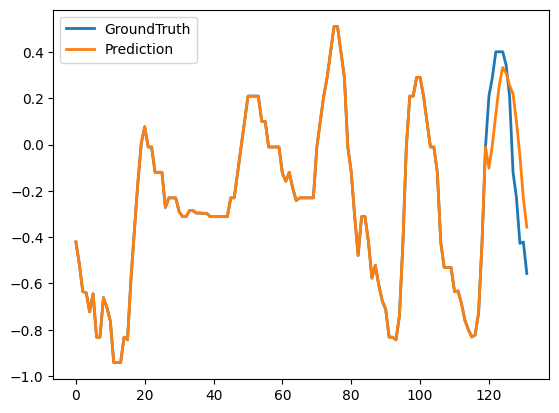

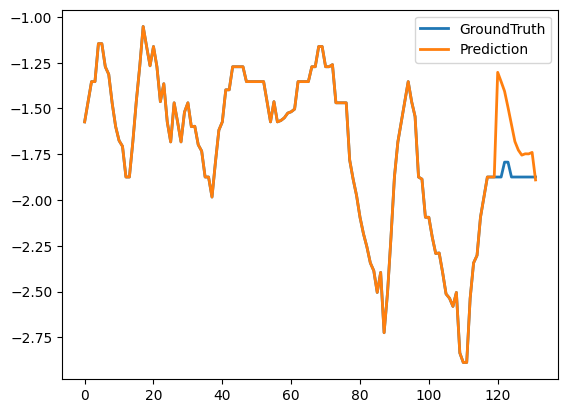

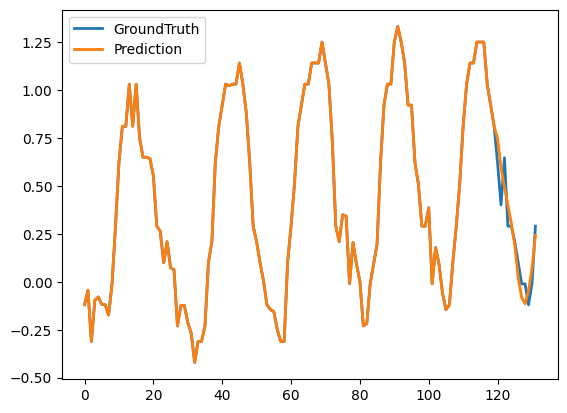

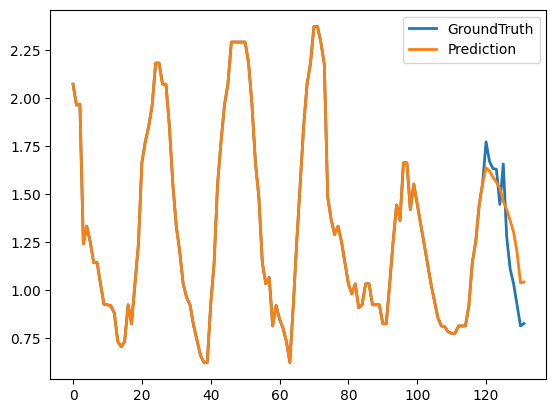

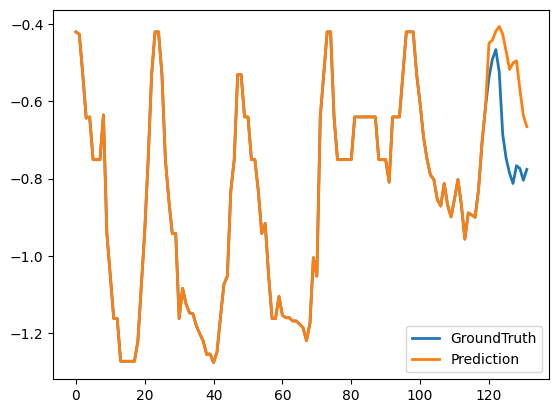

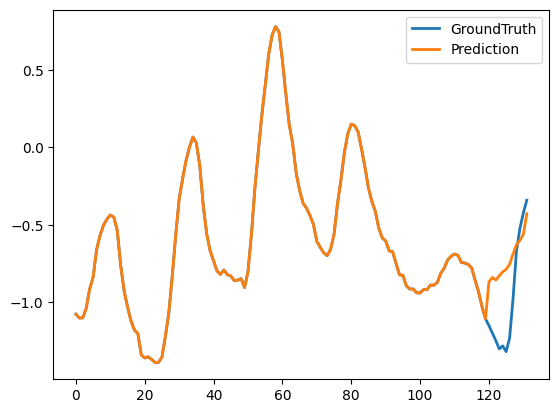

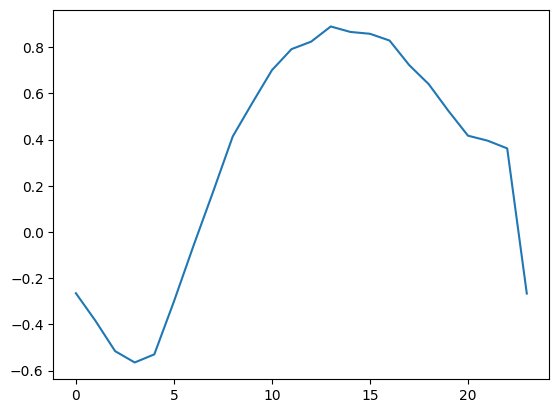

torch.Size([24])


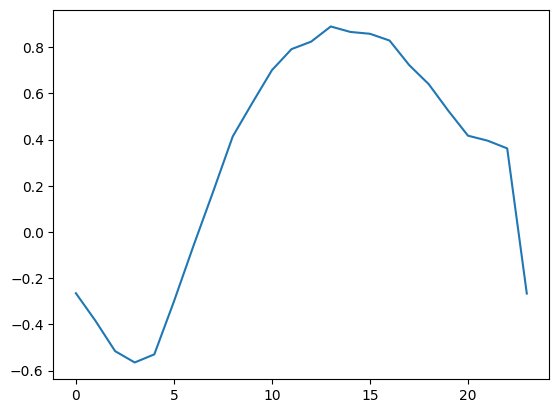

torch.Size([24])


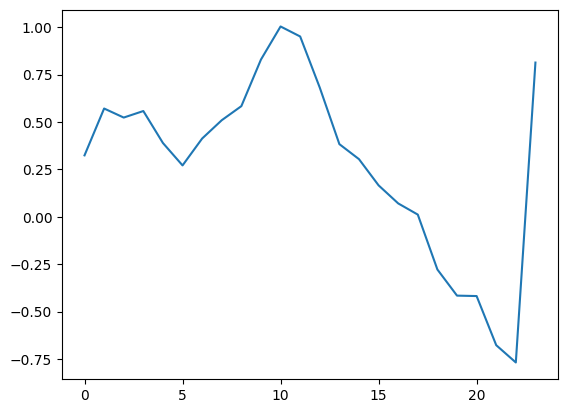

torch.Size([24])


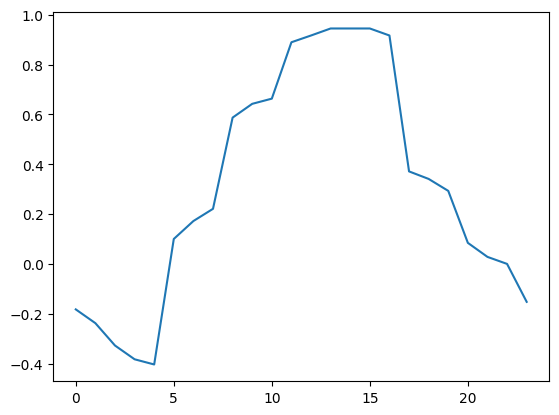

torch.Size([24])


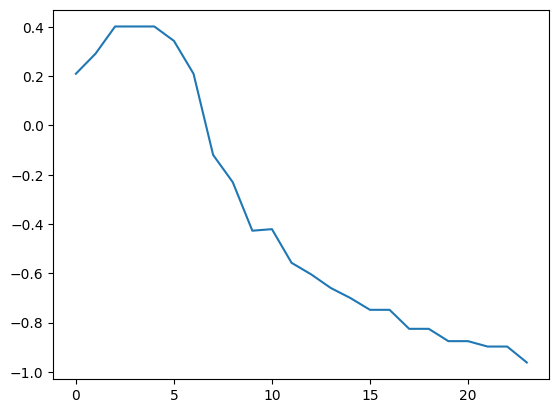

torch.Size([24])


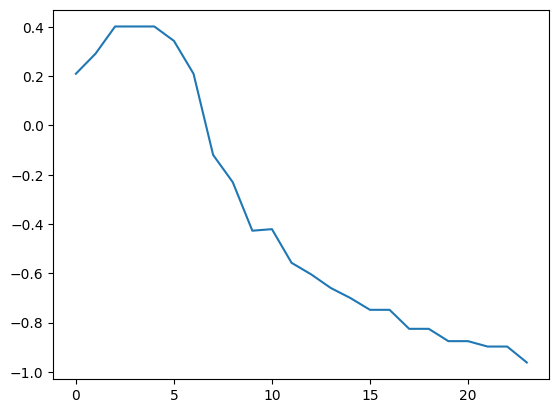

In [7]:
%matplotlib inline
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib
data_pred = np.load('./results/weather_96_24_univar_Autoformer_custom_ftMS_sl96_ll48_pl24_dm512_nh3_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/real_prediction.npy')
data_pred = torch.from_numpy(data_pred).permute(0,2,1)

plt.figure()
print(data_pred.shape)
plt.plot(data_pred[-1,-1,:])
print(data_pred[-1,-1,:].shape)
plt.show()
plt.plot(data_pred[0,-1,:])
print(data_pred[0,-1,:].shape)
plt.show()

'''
Ground Truth
'''
data_gt = np.load('./results/weather_96_24_univar_Autoformer_custom_ftMS_sl96_ll48_pl24_dm512_nh3_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/true.npy')
data_gt = torch.from_numpy(data_gt).permute(0,2,1)


plt.plot(data_gt[-1,-1,:])
print(data_gt[-1,-1,:].shape)
plt.show()
plt.plot(data_gt[0,-1,:])
print(data_gt[0,-1,:].shape)
plt.show()


